In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import popoff
import loadpaths
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
import os
from linear_model import PoolAcrossSessions
from scipy.stats import linregress
from Session import SessionLite, build_flu_array_single
from IPython.core.debugger import Pdb
ipdb = Pdb()

/home/jrowland/Documents/code/pop-off/popoff/popoff/loadpaths.py


In [3]:
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

COLORS = [
'#228E5E', # Hit green
'#DB3713', # Miss red
'#3A9DEF'
]

In [4]:
remove_targets = False
pas = PoolAcrossSessions(save_PCA=False, remove_targets=remove_targets)
lm = pas.linear_models[0]
pas.sessions

{3: instance Mouse J064, run 10 of Session class,
 7: instance Mouse RL070, run 29 of Session class,
 0: instance Mouse J065, run 10 of Session class}

In [5]:
session = pas.sessions[0]
session.__dict__.keys()

dict_keys(['mouse', 'run_number', 'flu_flavour', 'pkl_path', 'pre_seconds', 'post_seconds', 'pre_gap_seconds', 'post_gap_seconds', 'verbose', 'filter_threshold', 'name', 'tstart_galvo', 'trial_start', 'galvo_ms', 'subsets', 'trial_subsets', 'n_stim_arr', 'outcome', 'outcome_arr', 'frequency', 'pre_frames', 'post_frames', 'art_gap_start', 'final_pre_gap_tp', 'art_gap_stop', 'filter_ps_array', 'filter_ps_time', 'behaviour_trials', 'pre_rew_trials', 'decision', 'photostim', 'photostim_occ', 'autorewarded', 'unrewarded_hits', 'n_unique_stims', 'n_neurons', 'n_times', 'n_trials', 'n_unique_dec', 'occ_table', 'n_com_trials', 'unfiltered_n_cells', 'filtered_neurons', 'n_cells', 'av_ypix', 'av_xpix', 'plane_number', 's1s2_border', 's2_bool', 's1_bool', 'is_target', 'nonnan_trials', 'frames_use', 'tau_dict'])

In [6]:
def post_pre_subtract(arr, lm):
    
    post = np.mean(arr[:, :, lm.frames_map['post']], (0,2))
    pre = np.mean(arr[:, :, lm.frames_map['pre']], (0,2))
    
    return post - pre

In [7]:
def transfer_function(lm, region, outcome, exclude_easy=False):
    
    region_bool = lm.region_map[region]
    outcome_bool = lm.session.outcome == outcome
    if exclude_easy:  # This will currently break for fp and cr
        outcome_bool = np.logical_and(outcome_bool, lm.session.photostim==1)
    
    flu = lm.flu[:, outcome_bool, :]
    
    is_target = lm.session.is_target[:, :, lm.session.frames_use]
    is_target = is_target[:, outcome_bool, :]
    
    assert flu.shape == is_target.shape
    
    targets = np.ma.array(flu, mask=~is_target)
    
    non_targets = np.ma.array(flu[region_bool, :, :], mask=is_target[region_bool, :, :])
    
    input_ = post_pre_subtract(targets, lm)
    output_ = post_pre_subtract(non_targets, lm)
    
    return input_, output_

In [8]:
def whole_region_transfer(lm, outcome, exclude_easy=False):
    
    outcome_bool = lm.session.outcome == outcome
    
    if exclude_easy:
        outcome_bool = np.logical_and(outcome_bool, lm.session.photostim==1)
    
    flu = lm.flu[:, outcome_bool, :]
    
    input_ = post_pre_subtract(flu[lm.region_map['s1'], :, :], lm)
    output_ = post_pre_subtract(flu[lm.region_map['s2'], :, :], lm)
    
    return input_, output_

In [9]:
def multisession_transfer_function(pas, region, outcome, whole_region=False):
    
    input_ = []
    output_ = []
    for lm in pas.linear_models:
        if whole_region:
            io = whole_region_transfer(lm, outcome)
        else:
            io = transfer_function(lm, region, outcome)
        input_.append(io[0])
        output_.append(io[1])
    input_ = np.concatenate(input_)
    output_ = np.concatenate(output_)
    
    if outcome == 'hit':
        color = COLORS[0]
    elif outcome == 'miss':
        color = COLORS[1]
    else:
        color = 'black'
        
    plt.plot(input_, output_, '.', color=color)
    
    slope, intercept, r_value, p_value, std_err = linregress(input_, output_)
    xlims = plt.gca().get_xlim()
    x = np.linspace(xlims[0], xlims[1], 100)
    plt.plot(x, slope*x + intercept, color=color)
    
    plt.ylim(-0.2, 0.3)
    plt.xlim(-0.3, 0.3)
    if not whole_region:
        title_str = f'{region.upper()}, {outcome} trials\n Slope = {round(slope, 2)}, '\
                    f'R^2 = {round(r_value, 2)} p = {p_value:.2e}'
    else: 
        title_str = f'{outcome} trials\n Slope = {round(slope, 2)}, '\
                    f'R^2 = {round(r_value, 2)} p = {p_value:.2e}'
    
    plt.title(outcome.capitalize(), fontsize=30)

    plt.text(0.1, 0, f'Slope = {round(slope, 2)}', fontsize=20)

    if not whole_region:
        plt.xlabel('INPUT (Delta Activity targets)')
        if outcome != 'miss': plt.ylabel('OUTPUT (Delta Activity non-targets)')
    else:
        plt.xlabel('INPUT (Delta activity all cells S1)')
        if outcome != 'miss': plt.ylabel('OUTPUT (Delta Activity all cells S2)')


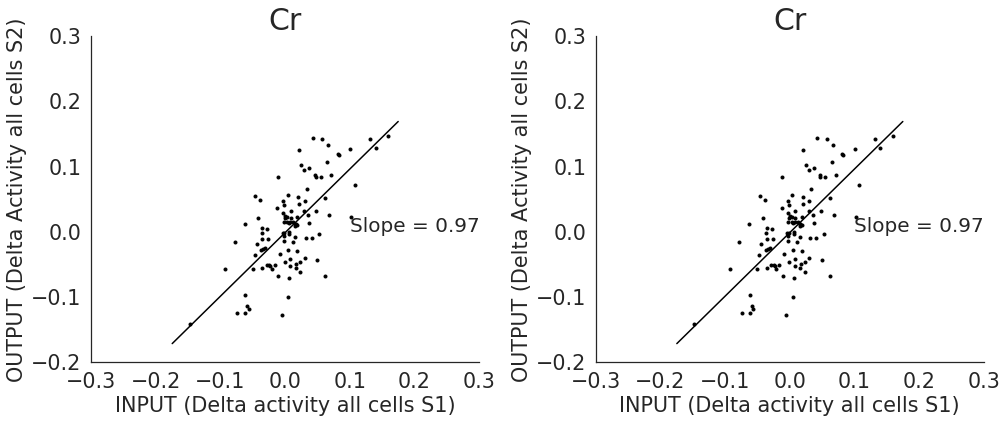

In [10]:
outcome = 'cr'

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
multisession_transfer_function(pas, 's1', outcome=outcome, whole_region=True)
plt.subplot(1,2,2)
multisession_transfer_function(pas, 's2', outcome=outcome, whole_region=True)
plt.subplots_adjust(wspace=0.3)

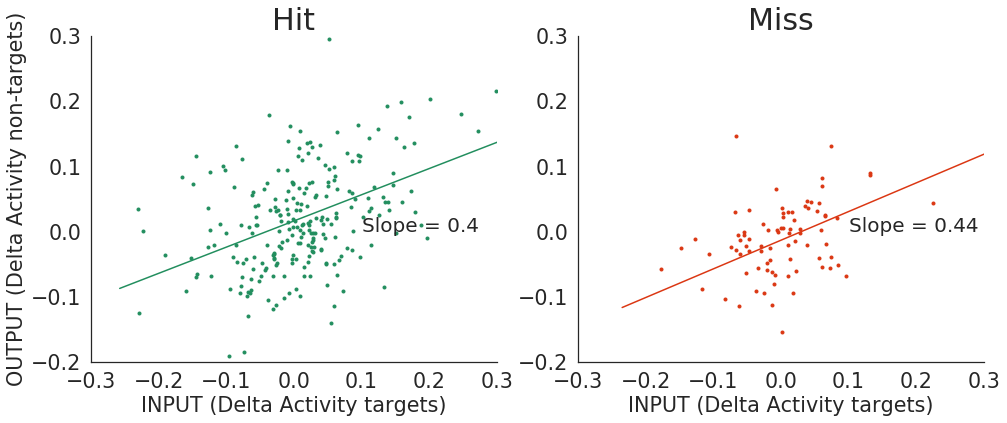

In [11]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
multisession_transfer_function(pas, 's2', outcome='hit', whole_region=False)
plt.subplot(1,2,2)
multisession_transfer_function(pas, 's2', outcome='miss', whole_region=False)

In [12]:
def session_flu(lm, region, outcome, frames, subtract_baseline=True):

    # Select region and trial outcomes
    if outcome != 'pre_reward':
        flu = lm.flu
        outcome_bool = lm.session.outcome == outcome
        exclude_easy = False
        if exclude_easy:
            outcome_bool = np.logical_and(outcome_bool, lm.session.photostim==1)
        flu = flu[:, outcome_bool, :]
    else:
        flu = lm.session.pre_rew_trials[:, :, lm.session.frames_use]
    
    flu = flu[lm.region_map[region], :, :]
    # Mean across cells
    flu = np.mean(flu, 0)
    
    if subtract_baseline:
        flu = baseline_subtraction(flu, lm)
        
    # Select desired frames
    if frames != 'all':
        flu = flu[:, lm.frames_map[frames]]
    
    return flu

In [13]:
def baseline_subtraction(flu, lm):
    
    ''' Takes a cell averaged flu matrix [n_trials x time]
        and subtracts pre-stim activity of an individual trial 
        from every timepoint in that trial.
        '''
    baseline = np.mean(flu[:, lm.frames_map['pre']], 1)
    flu = np.subtract(flu.T, baseline).T
    return flu

In [14]:
def multisesssion_flu(pas, region, outcome, frames):
    
    if outcome == 'hit':
        color = COLORS[0]
    elif outcome == 'miss':
        color = COLORS[1]
    elif outcome == 'pre_reward':
        color = COLORS[2]
        
    flu = []
    for lm in pas.linear_models:
        flu.append(session_flu(lm, region, outcome, frames))
    
    flu = np.vstack(flu)
    print(flu.shape)
    mean_flu = np.mean(flu, 0)
    std_flu = np.std(flu, 0) / flu.shape[0]  # This is too small
    
    if outcome != 'pre_reward':
        mean_flu[np.logical_not(lm.frames_map['all'])] = np.nan
        label = outcome.capitalize()
    else:
        label = 'Spontaneous\nReward'
    
    plt.plot(mean_flu, color=color, label=label)
    plt.fill_between(np.arange(len(mean_flu)), mean_flu+std_flu, mean_flu-std_flu, color=color)
    
    times_use = np.round(lm.times_use, 2)
    if frames == 'all':
        times_on_axis = np.array([-2, 0, 2, 4, 6]).astype('float')
    elif frames == 'pre':
        times_on_axis = np.array([-2, 0,]).astype('float')
    times_where = np.where(np.isin(times_use, times_on_axis))[0]
    plt.xticks(times_where, times_on_axis)
    
    plt.xlabel('time (seconds)', fontsize=28)
    plt.axhline(0, ls=':', color='grey')

    if region != 's2': plt.ylabel(r'$\Delta$F/F', fontsize=28)
    
    
    
    

(246, 241)
(85, 241)
(30, 241)
(246, 241)
(85, 241)
(30, 241)


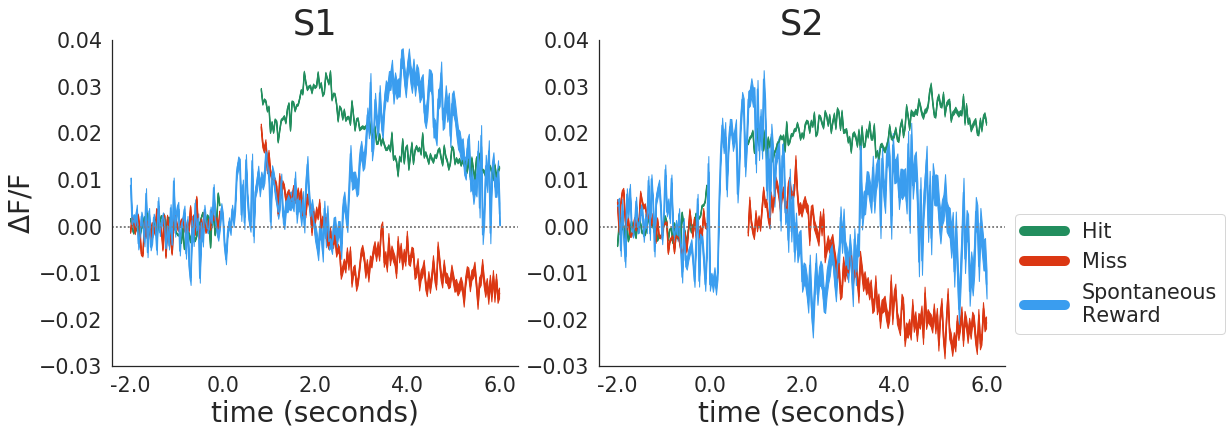

In [15]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
frames = 'all'
ylims = (-0.03, 0.04)

region = 's1'
multisesssion_flu(pas, region, 'hit', frames)
multisesssion_flu(pas, region, 'miss', frames)
multisesssion_flu(pas, region, 'pre_reward', frames)
plt.ylim(ylims)
plt.title(region.upper(), fontsize=35)

plt.subplot(1,2,2)
region = 's2'
multisesssion_flu(pas, region, 'hit', frames)
multisesssion_flu(pas, region, 'miss', frames)
multisesssion_flu(pas, region, 'pre_reward', frames)
plt.ylim(ylims)
plt.title(region.upper(), fontsize=35)
leg = plt.legend(bbox_to_anchor=[1, 0.5])
lines = leg.get_lines()
_ = [line.set_linewidth(10) for line in lines]
